# Introduction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing libraries

In [2]:
import numpy as np
import pandas as pd
import cv2
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os

# Loading the Dataset

In [3]:
df = pd.read_csv("/content/drive/Shareddrives/BMIN_5220/Code/Dataset/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


# Data Extraction

## Extracting Information about Glaucoma & Normal Eye Images from the Dataset

### Glaucome Images

In [4]:
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0

In [5]:
df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

In [6]:
left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
left_glaucoma[:15]

array(['95_left.jpg', '153_left.jpg', '167_left.jpg', '178_left.jpg',
       '247_left.jpg', '365_left.jpg', '583_left.jpg', '625_left.jpg',
       '746_left.jpg', '931_left.jpg', '1209_left.jpg', '1210_left.jpg',
       '1211_left.jpg', '1212_left.jpg', '1213_left.jpg'], dtype=object)

In [7]:
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma[:15]

array(['43_right.jpg', '167_right.jpg', '238_right.jpg', '247_right.jpg',
       '365_right.jpg', '583_right.jpg', '746_right.jpg', '931_right.jpg',
       '1209_right.jpg', '1210_right.jpg', '1211_right.jpg',
       '1212_right.jpg', '1213_right.jpg', '1214_right.jpg',
       '1215_right.jpg'], dtype=object)

In [8]:
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))

Number of images in left glaucoma: 332
Number of images in right glaucoma: 284


### Normal Images


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
print(len(glaucoma),len(normal))

616 500


## Creating Dataset from images

In [12]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/Shareddrives/BMIN_5220/Code/Dataset/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [13]:
dataset = create_dataset(glaucoma,1)

100%|██████████| 616/616 [03:32<00:00,  2.90it/s] 


In [14]:
len(dataset)

613

In [15]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


In [16]:
len(dataset)

1113

### Let's see some images

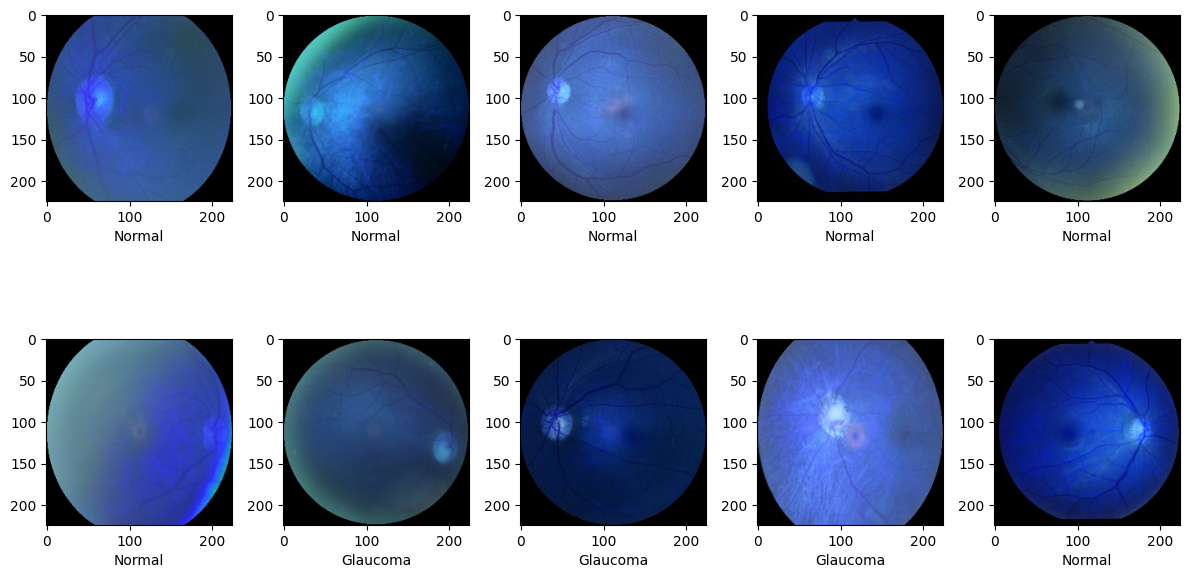

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

## Data Augmentation

In [18]:
train_datagen = ImageDataGenerator(rotation_range=5,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   zoom_range=0.2,  # zoom
                                   horizontal_flip=True,  # horizontal flip
                                   brightness_range=[0.2,0.8])  # brightness

### Dividing dataset into x(features) & y(target)

In [58]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [59]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

# Modeling

## VGG19 Model

In [21]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)


In [60]:
vgg = tensorflow.keras.applications.VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

def create_model():
  model = Sequential()
  model.add(vgg)
  model.add(Flatten())
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=0.01) ,loss="binary_crossentropy",metrics=["accuracy"])

  return model

model = create_model()

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [61]:
# path_checkpoint = "r/content/drive/Shareddrives/BMIN_5220/Code/model/vgg.h5"
# directory_checkpoint = os.path.dirname(path_checkpoint)

checkpoint_path = "r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_vgg_adam_01.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

### Training

In [62]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# history = model.fit(train_datagen.flow(x_train,y_train,
#                                        batch_size=32, 
#                                        seed=27,
#                                        shuffle=False),
#                     epochs=15,validation_data=(x_test,y_test),
#                     verbose=1,callbacks=[checkpoint])

history = model.fit(x_train,y_train,batch_size = 32,
                    epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint])


Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 24.9024 - accuracy: 0.6562
Epoch 1: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_vgg_adam_01.ckpt
28/28 [==============================] - 7s 230ms/step - loss: 24.9024 - accuracy: 0.6562 - val_loss: 10.7259 - val_accuracy: 0.7713
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 5.7076 - accuracy: 0.8787
Epoch 2: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_vgg_adam_01.ckpt
28/28 [==============================] - 6s 217ms/step - loss: 5.7076 - accuracy: 0.8787 - val_loss: 9.2744 - val_accuracy: 0.8430
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.9793 - accuracy: 0.9596
Epoch 3: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_vgg_adam_01.ckpt
28/28 [==============================] - 6s 218ms/step - loss: 0.9793 - accuracy: 0.9596 - val_loss: 5.6448 - val_accuracy: 0.8789
Epoch 4/15
28/28 [=

### Evaluation

In [63]:
loaded_model = create_model()

loaded_model.load_weights(checkpoint_path)

loss,accuracy = loaded_model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 154ms/step - loss: 8.6141 - accuracy: 0.8924
loss: 8.614089965820312
Accuracy: 0.8923766613006592


In [64]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = loaded_model.predict(x_test) 
classes_x=np.argmax(y_pred,axis=1)

7/7 [==============================] - 1s 155ms/step


In [65]:
m = [0 if i<0.5 else 1 for i in y_pred]

print(m)
y_pred = m

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1]


In [66]:
accuracy_score(y_test,y_pred)

0.8923766816143498

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.80      0.87        96
           1       0.87      0.96      0.91       127

    accuracy                           0.89       223
   macro avg       0.90      0.88      0.89       223
weighted avg       0.90      0.89      0.89       223



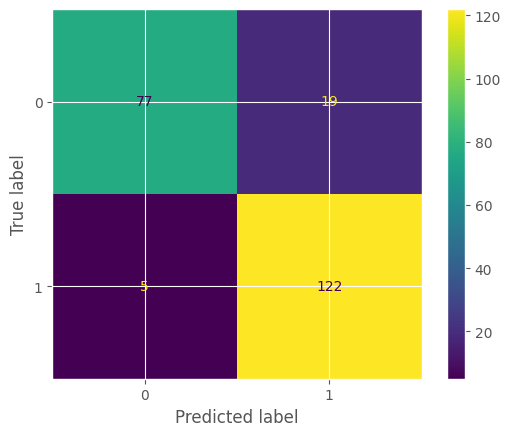

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["Normal","Cataract"]

cm = confusion_matrix(y_test, m, labels=[0,1])
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=class_names)
disp.plot()

plt.show()


### Learning Curves

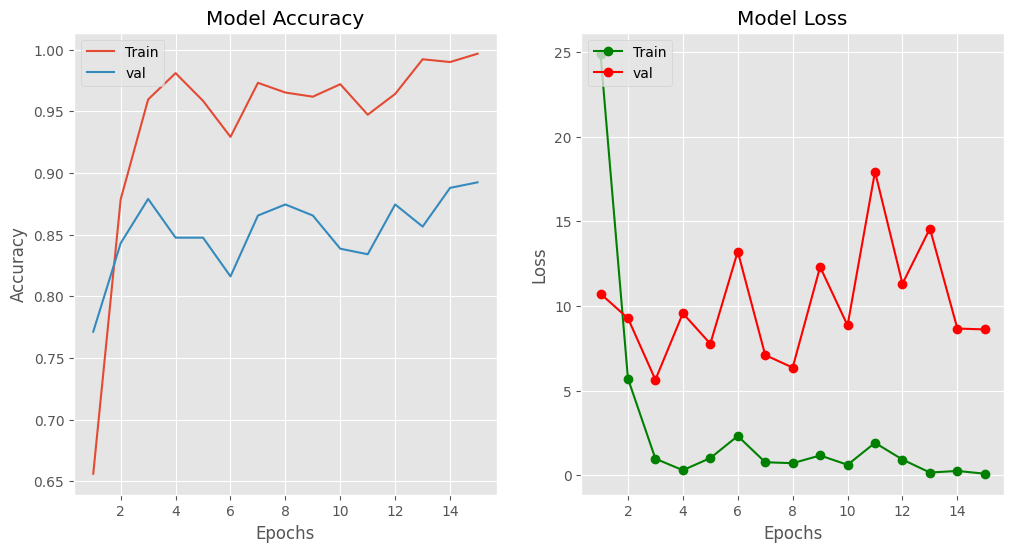

In [69]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"])#,"go-")
plt.plot(epochs,history.history["val_accuracy"])#,"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Prediction:

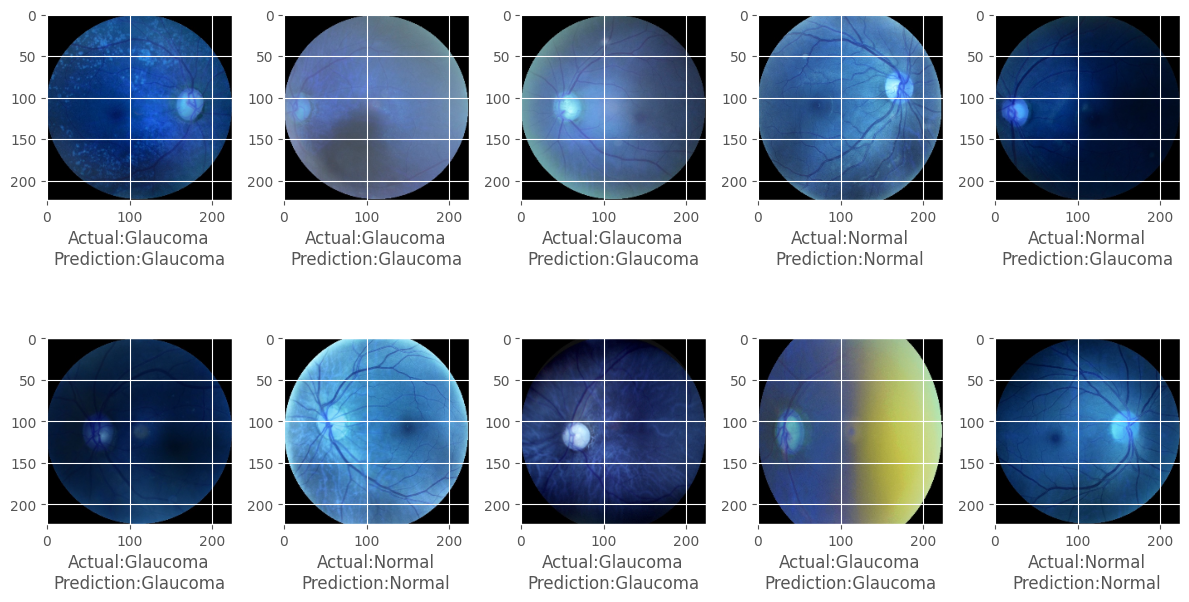

In [70]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Glaucoma"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

## ResNet Model

In [33]:
resnet = tensorflow.keras.applications.ResNet50(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in resnet.layers:
    layer.trainable = False

def create_model():
  model = Sequential()
  model.add(resnet)
  model.add(Flatten())
  model.add(Dense(1,activation="sigmoid"))

  model.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=0.005) ,loss="binary_crossentropy",metrics=["accuracy"])

  return model

model = create_model()

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 23,688,065
Trainable params: 100,353
Non-trainable params: 23,587,712
_________________________________________________________________


### Training

In [34]:
checkpoint_path = "r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_da_resnet_adam_005.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [35]:
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_datagen.flow(x_train,y_train,
                                       batch_size=32, 
                                       seed=27,
                                       shuffle=False),
                    epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint])

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 12.7904 - accuracy: 0.6438
Epoch 1: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_da_resnet_adam_005.ckpt
28/28 [==============================] - 22s 571ms/step - loss: 12.7904 - accuracy: 0.6438 - val_loss: 11.9035 - val_accuracy: 0.6592
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 8.5556 - accuracy: 0.7427
Epoch 2: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_da_resnet_adam_005.ckpt
28/28 [==============================] - 14s 500ms/step - loss: 8.5556 - accuracy: 0.7427 - val_loss: 5.8296 - val_accuracy: 0.7489
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 7.9240 - accuracy: 0.7640
Epoch 3: saving model to r/content/drive/Shareddrives/BMIN_5220/Code/model/glaucoma_da_resnet_adam_005.ckpt
28/28 [==============================] - 15s 523ms/step - loss: 7.9240 - accuracy: 0.7640 - val_loss: 8.1620 - val_accuracy: 0.

### Evaluation

In [36]:
loaded_model = create_model()

loaded_model.load_weights(checkpoint_path)

loss,accuracy = loaded_model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 2s 98ms/step - loss: 6.3333 - accuracy: 0.7892
loss: 6.333258152008057
Accuracy: 0.7892376780509949


In [37]:
y_pred = loaded_model.predict(x_test) 
classes_x=np.argmax(y_pred,axis=1)

7/7 [==============================] - 1s 89ms/step


In [38]:
m = [0 if i<0.5 else 1 for i in y_pred]

print(m)
y_pred = m

[1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]


In [39]:
accuracy_score(y_test,y_pred)

0.7892376681614349

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       101
           1       0.86      0.74      0.79       122

    accuracy                           0.79       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.79      0.79       223



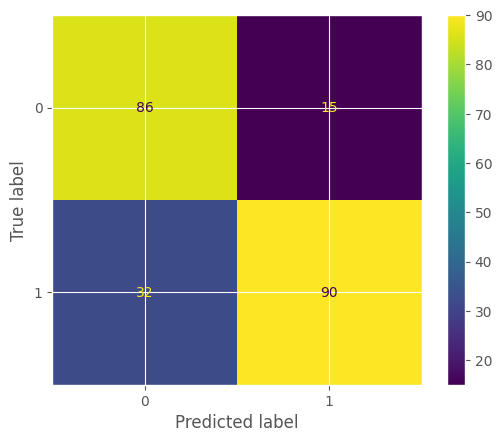

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ["Normal","Cataract"]

cm = confusion_matrix(y_test, m, labels=[0,1])
    
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=class_names)
disp.plot()

plt.show()

### Learning Curves

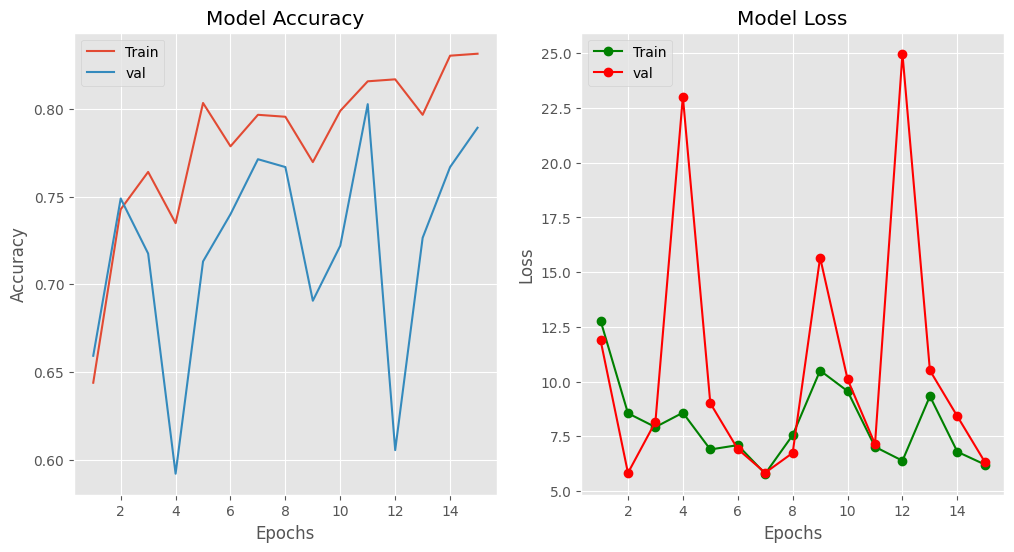

In [42]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"])#,"go-")
plt.plot(epochs,history.history["val_accuracy"])#,"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

### Prediction

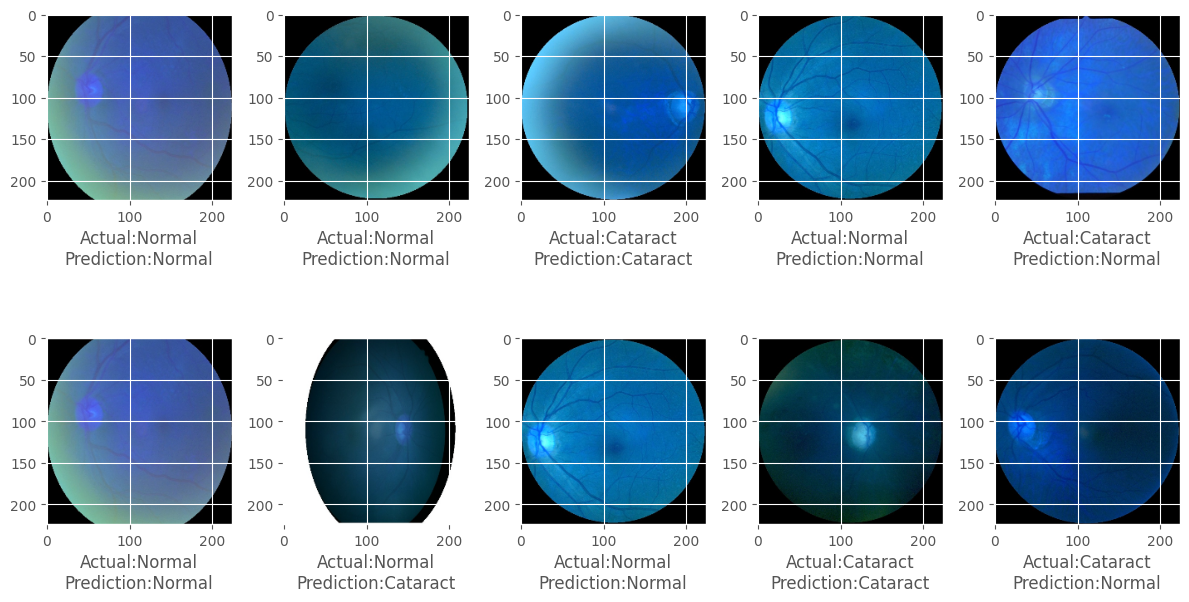

In [43]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()